In [1]:
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

In [2]:
class Node:
    def __init__(self, value=None, symbol=None, is_leaf=False, lc=None, rc = None):
        self.value = value
        self.symbol = symbol
        self.left_children = lc
        self.right_children = rc
        self.is_leaf = is_leaf
        self.code = None

class Huffman_code:
    def __init__(self):
        self.stats = []
        self.root = None
        self.codes = dict()

    def calculate_probabities(self, sequence):
        for symbola in set(sequence):
            self.stats.append(Node(value = sequence.count(symbola), symbol=symbola, is_leaf=True))
        self.stats = sorted(self.stats, key=lambda x: x.value, reverse=True)

    def create_tree(self):
        while len(self.stats) != 1:
            self.creation(self.stats[-1], self.stats[-2])

    def creation(self, node_right, node_left):
        if len(self.stats) != 2:
            self.stats = self.stats[:-2]
            self.stats.append(Node(value = node_left.value + node_right.value, rc = node_right, lc = node_left))
            self.stats = sorted(self.stats, key=lambda x: x.value, reverse=True)
        else:
            self.root = Node(value = node_left.value + node_right.value, rc = node_right, lc = node_left)
            self.stats = [Node(value = node_left.value + node_right.value, rc = node_right, lc = node_left)]

    def get_codes(self, root, code=''):
        try:
            if root.is_leaf:
                root.code = code
                self.codes[root.symbol] = root.code
            self.get_codes(root.left_children, code=code + '0')
            self.get_codes(root.right_children, code=code + '1')

        except AttributeError:
            None

    def calculate_encode(self, sequence):
        result = ''
        self.calculate_probabities(sequence)
        self.create_tree()
        self.get_codes(self.root)
        for element in sequence:
            result = result + self.codes[element]
        return result, self.root

    def huffman_decode(self, code, tree):
        current_node = tree
        decoded_string = ""

        for bit in code:
            if bit == "0":
                current_node = current_node.left_children
            else:
                current_node = current_node.right_children

            if current_node.is_leaf:
                decoded_string += current_node.symbol
                current_node = tree

        return decoded_string

    def get_leaves(self, node, leaves=[]):
        if node is None:
            return
        if node.is_leaf:
            leaves.append(node)
            return
        self.get_leaves(node.left_children, leaves)
        self.get_leaves(node.right_children, leaves)
        return {leaf.code: leaf.symbol for leaf in leaves}

In [3]:
class LZ77:
    def __init__(self, buffer_length = 10):
        self.buffer_length = buffer_length

    def compress(self, text):
        read = 0
        length_data = len(text)
        buffer = ''
        code = []
        while read < length_data:
            offset, length, next, buffer, read = self.best_matches_compress(text, buffer, read)
            code.append((offset, length, next))
        return code

    def decompress(self, code):

        message = ''
        for index, length, next in code:
            if not index:
                message += next
            else:
                start = len(message) - index
                for i in range(length):
                    message += message[start + i]
                message += next
        return message

    def best_matches_compress (self, data, buffer, position):
        offset = 0
        length = 0
        buf_len = len(buffer)
        index = 0
        message = ''
        next = data[position]
        try:
            while True:
                message += next
                if index + length > buf_len:
                    if repetition:
                        if repetition[length % len_rep] == data[position]:
                            length += 1
                            position += 1
                            next = data[position]
                        else:
                            break
                    else:
                        break
                else:
                    if message in buffer:
                        index = buffer.index(message)
                        offset = buf_len - index
                        length += 1
                        position += 1
                        next = data[position]
                        repetition = buffer[index:]
                        len_rep = len(repetition)
                    else:
                        break
        except IndexError:
            next = ''
        return (offset, length, next, (buffer + message)[-self.buffer_length:], position + 1)


In [4]:
class Lzw:
    def __init__(self):
        self.dict_encodes = dict()
        self.dict_rough_encodes = dict()
        self.codes = list()

    def encode(self, sequence):
        code_number = 0
        start = 0
        end = 2
        for symbol in sorted(list(set(sequence))):
            self.dict_encodes[symbol] = code_number
            self.dct = {}
            self.dict_rough_encodes[code_number] = symbol
            code_number += 1

        while len(sequence) > end:
            symbols = sequence[start:end]
            cropper = 2
            if symbols not in self.dict_encodes.keys():
                self.dict_encodes[symbols] = code_number
                self.dct[code_number] = symbols
                self.codes.append(self.dict_encodes[symbols[:-1]])
                start += len(symbols) - 1
                end += 1
                code_number += 1

            else:
                try:
                    while symbols in self.dict_encodes and symbols != sequence[start: end+1]:
                        end += 1
                        cropper += 1
                        symbols = sequence[start: end]
                except IndexError:
                    pass
                self.codes.append(self.dict_encodes[symbols[:-1]])
                self.dict_encodes[symbols] = code_number
                self.dct[code_number] = symbols
                start = end - 1
                end += 1
                code_number += 1

        info = sequence[start:]
        if len(info) > 1 and info != '':
            self.codes.append(self.dict_encodes[info[:-1]])
            self.codes.append(self.dict_encodes[info[-1]])
        elif len(info) == 1:
            self.codes.append(self.dict_encodes[info])
        return self.codes, self.dict_rough_encodes

    def decode(self, codes, start_dict):
        result = []
        lenght = len(start_dict)
        previos = start_dict[codes.pop(0)]
        result.append(previos)
        for code in codes:
            if code in start_dict:
                to_add = start_dict[code]
                start_dict[lenght] = previos + to_add[0]
                lenght += 1
                result.append(to_add)
                previos = to_add
            else:
                to_add = previos + previos[0]
                start_dict[lenght] = to_add
                lenght += 1
                result.append(to_add)
                previos = to_add
        return ''.join(result)

In [5]:
class Deflate(LZ77, Huffman_code):
    def __init__(self, buffer_length):
        LZ77.__init__(self, buffer_length)
        Huffman_code.__init__(self)

    def huffman_decode(self, code, tree):
        current_node = tree
        decoded_result = []

        for bit in code:
            if bit == "0":
                current_node = current_node.left_children
            else:
                current_node = current_node.right_children

            if current_node.is_leaf:
                decoded_result.append(current_node.symbol)
                current_node = tree

        return decoded_result


    def deflate_encode(self, data):
        test = self.compress(data)
        to_analyse = []

        for i in test:
            to_analyse += list(i)

        return self.calculate_encode(to_analyse)

    def deflate_decode(self, data, node):
        test = self.huffman_decode(data, node)
        i = 0
        to_analyse = []
        length = len(test)
        while i < length:
            to_analyse.append((test[i], test[i+1], test[i+2]))
            i += 3
        return self.decompress(to_analyse)


Checking of correct working on novel "ChornaRada"
Length of buffer for LZ77 and Deflate - 100

In [6]:
with open('test_documents/596kb.txt', encoding='utf-8') as file: #It's txt file of Hunter games
    data = file.read()

lzw = Lzw()
compresed_lzw = lzw.encode(data)
decode_lzw = lzw.decode(*compresed_lzw)
print(f"LZW : Data and decompressed data is equal - {data == decode_lzw}")

lz77 = LZ77(100)
compresed_lz77 = lz77.compress(data)
decode_lz77 = lz77.decompress(compresed_lz77)
print(f"LZ77: Data and decompressed data is equal - {data == decode_lz77}")

hufman = Huffman_code()
compress_huffman = hufman.calculate_encode(data)
decode_huffman = hufman.huffman_decode(*compress_huffman)
print(f"Huffman: Data and decompressed data is equal - {data == decode_huffman}")

deflate = Deflate(100)
compress_deflate = deflate.deflate_encode(data)
decode_deflate = deflate.deflate_decode(*compress_deflate)
print(f"Deflate: Data and decompressed data is equal - {data == decode_deflate}")

LZW : Data and decompressed data is equal - True
LZ77: Data and decompressed data is equal - True
Huffman: Data and decompressed data is equal - True
Deflate: Data and decompressed data is equal - True


LZ77 comperasion runtime of defferent buffer size

In [7]:
def comparison_lz77(len_buf, data):
    NUM_OF_ITERATIONS = 10
    time_taken = 0
    for i in tqdm(range(NUM_OF_ITERATIONS)):
        # note that we should not measure time of graph creation
        my_lz77 = LZ77(len_buf)

        start = time.time()
        my_lz77.compress(data)
        end = time.time()

        time_taken += end - start

    print(time_taken/NUM_OF_ITERATIONS)


In [8]:
os.listdir('test_files')

['10kb.txt',
 '1mb.txt',
 '1_11mb.txt',
 '1_1mb.txt',
 '1_2mb.txt',
 '2_6mb.txt',
 '35kb.txt',
 '3mb.txt',
 '600kb.txt']

100%|██████████| 10/10 [00:01<00:00,  6.11it/s]


0.16319420337677001


100%|██████████| 10/10 [00:01<00:00,  6.27it/s]


0.15885841846466064


100%|██████████| 10/10 [00:01<00:00,  6.58it/s]


0.15152113437652587


100%|██████████| 10/10 [00:01<00:00,  6.40it/s]


0.1556792974472046


100%|██████████| 10/10 [00:01<00:00,  5.78it/s]


0.1721634864807129


100%|██████████| 10/10 [00:01<00:00,  5.92it/s]


0.16811025142669678


100%|██████████| 10/10 [00:01<00:00,  5.38it/s]


0.18500359058380128


100%|██████████| 10/10 [00:02<00:00,  3.90it/s]


0.255689001083374


100%|██████████| 10/10 [00:02<00:00,  3.69it/s]


0.2701728105545044


100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


0.2877016305923462


100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


0.30193510055541994


100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


0.31944785118103025


100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


0.3312279462814331


100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


0.34271314144134524


100%|██████████| 10/10 [00:03<00:00,  2.81it/s]

0.35597686767578124


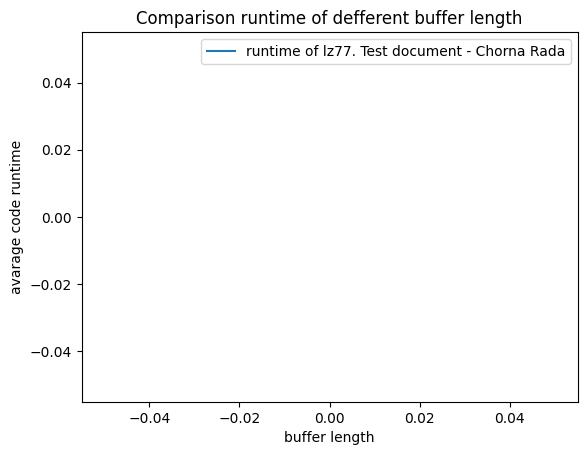

In [9]:
buffers_length = [1, 5, 20, 50, 75, 100, 200, 300, 400,  500, 600, 700, 800, 900, 1000]
own_times = []
with open('ChornaRada.txt', encoding='utf-8') as file:
  data = file.read()
for buf_length in buffers_length:
  own_time = comparison_lz77(buf_length, data)
  own_times.append(own_time)

plt.plot(buffers_length, own_times, label ='runtime of lz77. Test document - Chorna Rada')
plt.xlabel('buffer length')
plt.ylabel('avarage code runtime')
plt.title("Comparison runtime of defferent buffer length")
plt.legend()

In [10]:
def Encode_algo(data):
  NUM_OF_ITERATIONS = 10

  time_lz77 = 0
  time_lzw = 0
  time_huffman = 0
  time_deflate = 0
  for i in tqdm(range(NUM_OF_ITERATIONS)):
      
      # note that we should not measure time of graph creation
      lz77 = LZ77(100)
      lzw = Lzw()
      deflate = Deflate(100)
      huffman = Huffman_code()

      start_lz77 = time.time()
      lz77_encode = lz77.compress(data)
      end_lz77 = time.time()

      start_lzw = time.time()
      lzw_encode = lzw.encode(data)
      end_lzw = time.time()

      start_huffman = time.time()
      huffman_encode = huffman.calculate_encode(data)
      end_huffman = time.time()

      start_deflate = time.time()
      deflate_encode = deflate.deflate_encode(data)
      end_deflate = time.time()




      time_lz77 += end_lz77 - start_lz77
      time_lzw += end_lzw - start_lzw
      time_huffman += end_huffman - start_huffman
      time_deflate += end_deflate - start_deflate

      
  return(time_lz77/NUM_OF_ITERATIONS, time_lzw/NUM_OF_ITERATIONS, time_huffman/NUM_OF_ITERATIONS, time_deflate/NUM_OF_ITERATIONS)

In [11]:
def Decode_algo(data):
  NUM_OF_ITERATIONS = 10

  time_lz77 = 0
  time_lzw = 0
  time_huffman = 0
  time_deflate = 0
  for i in tqdm(range(NUM_OF_ITERATIONS)):
      
      # note that we should not measure time of graph creation
      lz77 = LZ77(100)
      lzw = Lzw()
      deflate = Deflate(100)
      huffman = Huffman_code()

      lz77_encode = lz77.compress(data)
      start_lz77 = time.time()
      lz77_decode = lz77.decompress(lz77_encode)
      end_lz77 = time.time()

      lzw_encode = lzw.encode(data)
      start_lzw = time.time()
      lzw_decode = lzw.decode(*lzw_encode)
      end_lzw = time.time()
      
      huffman_encode = huffman.calculate_encode(data)
      start_huffman = time.time()
      huffman_decode = huffman.huffman_decode(*huffman_encode)
      end_huffman = time.time()
      
      deflate_encode = deflate.deflate_encode(data)
      start_deflate = time.time()
      deflate_decode = deflate.deflate_decode(*deflate_encode)
      end_deflate = time.time()




      time_lz77 += end_lz77 - start_lz77
      time_lzw += end_lzw - start_lzw
      time_huffman += end_huffman - start_huffman
      time_deflate += end_deflate - start_deflate

      
  return(time_lz77/NUM_OF_ITERATIONS, time_lzw/NUM_OF_ITERATIONS, time_huffman/NUM_OF_ITERATIONS, time_deflate/NUM_OF_ITERATIONS)

In [12]:
def runtime_algo(data):
  NUM_OF_ITERATIONS = 10

  time_lz77 = 0
  time_lzw = 0
  time_huffman = 0
  time_deflate = 0
  for i in tqdm(range(NUM_OF_ITERATIONS)):
      
      # note that we should not measure time of graph creation
      lz77 = LZ77(100)
      lzw = Lzw()
      deflate = Deflate(100)
      huffman = Huffman_code()

      start_lz77 = time.time()
      lz77_encode = lz77.compress(data)
      lz77_decode = lz77.decompress(lz77_encode)
      end_lz77 = time.time()

      start_lzw = time.time()
      lzw_encode = lzw.encode(data)
      lzw_decode = lzw.decode(*lzw_encode)
      end_lzw = time.time()
      
      start_huffman = time.time()
      huffman_encode = huffman.calculate_encode(data)
      huffman_decode = huffman.huffman_decode(*huffman_encode)
      end_huffman = time.time()
      
      start_deflate = time.time()
      deflate_encode = deflate.deflate_encode(data)
      deflate_decode = deflate.deflate_decode(*deflate_encode)
      end_deflate = time.time()




      time_lz77 += end_lz77 - start_lz77
      time_lzw += end_lzw - start_lzw
      time_huffman += end_huffman - start_huffman
      time_deflate += end_deflate - start_deflate

      
  return(time_lz77/NUM_OF_ITERATIONS, time_lzw/NUM_OF_ITERATIONS, time_huffman/NUM_OF_ITERATIONS, time_deflate/NUM_OF_ITERATIONS)

100%|██████████| 10/10 [00:02<00:00,  4.46it/s]


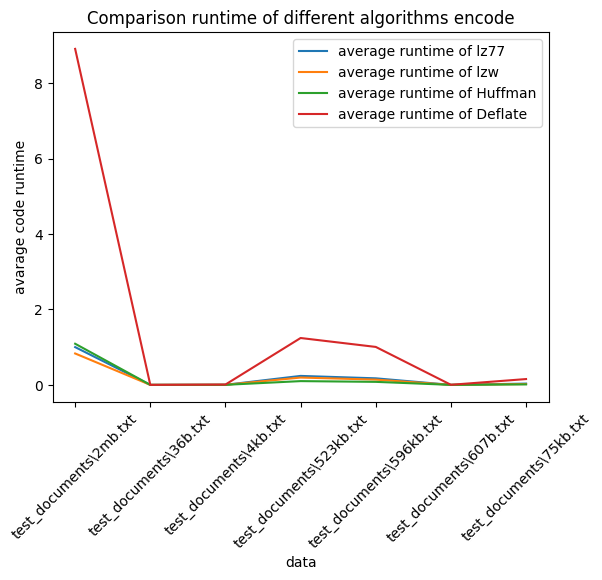

In [13]:
datas = os.listdir('test_documents')
datas = [os.path.join('test_documents', data) for data in datas if '.txt' in data]
times_lz77 = []
times_lzw = []
times_huffman = []
times_deflate = []
for data in datas:
    if '.txt' not in data:
        continue
    with open(data, encoding='utf-8') as file:
        data = file.read()
    time_lz77, time_lzw, time_huffman, time_deflate = Encode_algo(data)
    times_lz77.append(time_lz77)
    times_lzw.append(time_lzw)
    times_huffman.append(time_huffman)
    times_deflate.append(time_deflate)

plt.plot(datas, times_lz77, label ='average runtime of lz77')
plt.plot(datas, times_lzw, label ='average runtime of lzw')
plt.plot(datas, times_huffman, label ='average runtime of Huffman')
plt.plot(datas, times_deflate, label ='average runtime of Deflate')
plt.xticks(rotation=45)

plt.xlabel('data')
plt.ylabel('avarage code runtime')
plt.title("Comparison runtime of different algorithms encode")
plt.legend()

Here you can see code to compare default weigth of files and weight of decoded files.

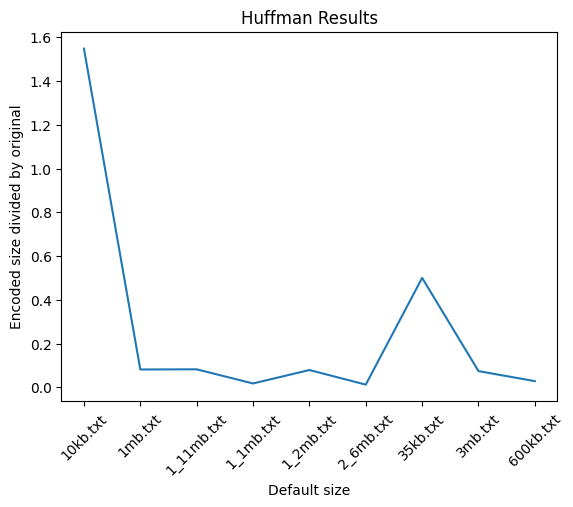

In [35]:
file_names=['10kb.txt',
            '1mb.txt',
            '1_11mb.txt',
            '1_1mb.txt',
            '1_2mb.txt',
            '2_6mb.txt',
            '35kb.txt',
            '3mb.txt',
            '600kb.txt']

delta_sizes_huffman = list()
for name in file_names:
    with open('test_files\\' + name, encoding='utf-8', errors='ignore') as file:
        data = file.read()

    huffman = Huffman_code()
    compressed_huffman = huffman.calculate_encode(data)[0]
    weight_encoded = len(compressed_huffman)/64 + sum([len(element) for element in huffman.get_leaves(huffman.root).keys()]) + sum([len(element) for element in huffman.get_leaves(huffman.root).values()])


    delta_sizes_huffman.append(weight_encoded/(os.path.getsize('test_files\\' + name)))

plt.plot(file_names, delta_sizes_huffman)
plt.xlabel('Default size')
plt.ylabel('Encoded size divided by original')
plt.title('Huffman Results')
plt.xticks(rotation=45)

# Displaying the plot
plt.show()



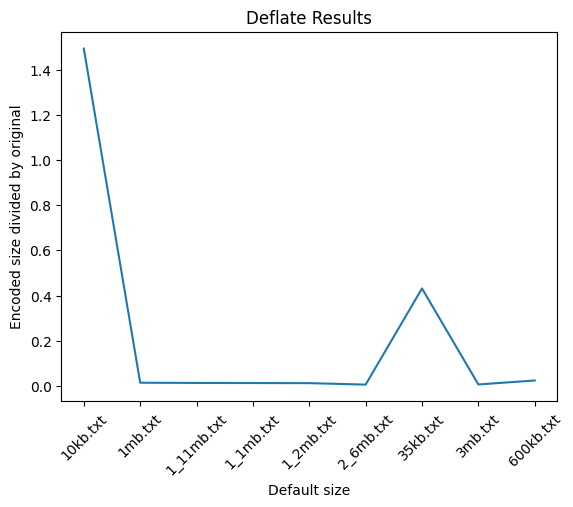

In [34]:
file_names=['10kb.txt',
            '1mb.txt',
            '1_11mb.txt',
            '1_1mb.txt',
            '1_2mb.txt',
            '2_6mb.txt',
            '35kb.txt',
            '3mb.txt',
            '600kb.txt']

delta_sizes_deflate = list()
for name in file_names:
    with open('test_files\\' + name, encoding='utf-8', errors='ignore') as file:
        data = file.read()

    deflate = Deflate(150)
    compressed_deflate = deflate.deflate_encode(data)
    weight_encoded = len(compressed_deflate)/64 + sum([len(element) for element in deflate.get_leaves(huffman.root).keys()]) + sum([len(element) for element in deflate.get_leaves(huffman.root).values()])


    delta_sizes_deflate.append(weight_encoded/os.path.getsize('test_files\\' + name))

plt.plot(file_names, delta_sizes_deflate)
plt.xlabel('Default size')
plt.ylabel('Encoded size divided by original')
plt.title('Deflate Results')
plt.xticks(rotation=45)

# Displaying the plot
plt.show()


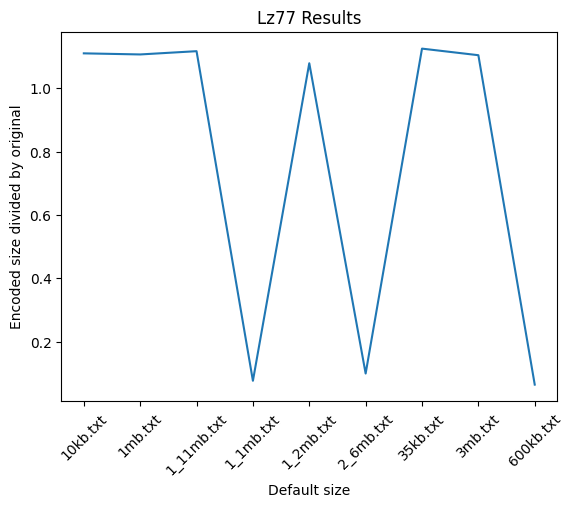

In [36]:
file_names=['10kb.txt',
            '1mb.txt',
            '1_11mb.txt',
            '1_1mb.txt',
            '1_2mb.txt',
            '2_6mb.txt',
            '35kb.txt',
            '3mb.txt',
            '600kb.txt']

delta_sizes_lz77 = list()
for name in file_names:
    with open('test_files\\' + name, encoding='utf-8', errors='ignore') as file:
        data = file.read()

    lz77_encode = lz77.compress(data)

    weight_encoded = (len(lz77_encode))*3


    delta_sizes_lz77.append(weight_encoded/os.path.getsize('test_files\\' + name))

plt.plot(file_names, delta_sizes_lz77)
plt.xlabel('Default size')
plt.ylabel('Encoded size divided by original')
plt.title('Lz77 Results')
plt.xticks(rotation=45)

# Displaying the plot
plt.show()



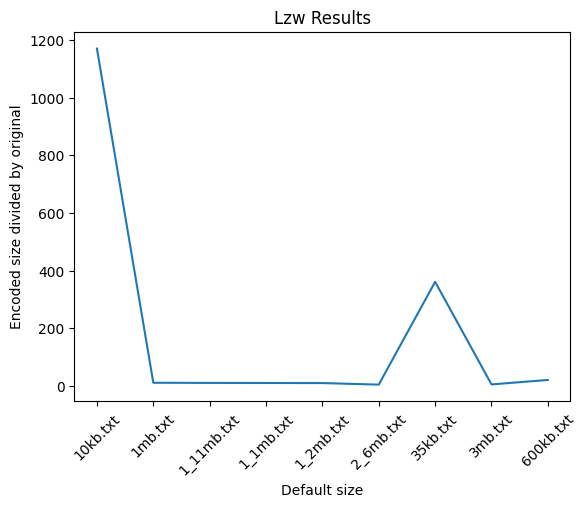

In [39]:
file_names=['10kb.txt',
            '1mb.txt',
            '1_11mb.txt',
            '1_1mb.txt',
            '1_2mb.txt',
            '2_6mb.txt',
            '35kb.txt',
            '3mb.txt',
            '600kb.txt']

delta_sizes_lzw = list()
for name in file_names:
    with open('test_files\\' + name, encoding='utf-8', errors='ignore') as file:
        data = file.read()

    lzw_encode = lzw.encode(data)

    # weight_encoded = (len(lz77_encode))*3)
    weight_encoded = len(lzw_encode[0]) * 2
    # print(weight_encoded, os.path.getsize('test_files\\' + name))
    delta_sizes_lzw.append(weight_encoded/os.path.getsize('test_files\\' + name))


plt.plot(file_names, delta_sizes_lzw)
plt.xlabel('Default size')
plt.ylabel('Encoded size divided by original')
plt.title('Lzw Results')
plt.xticks(rotation=45)

# Displaying the plot
plt.show()


Total comparison

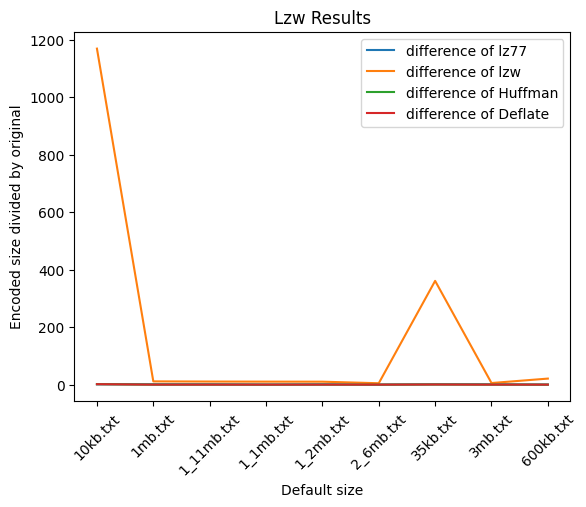

In [40]:
plt.plot(file_names, delta_sizes_lz77, label ='difference of lz77')
plt.plot(file_names, delta_sizes_lzw, label ='difference of lzw')
plt.plot(file_names, delta_sizes_huffman, label ='difference of Huffman')
plt.plot(file_names, delta_sizes_deflate, label ='difference of Deflate')
plt.xticks(rotation=45)

plt.xlabel('Default size')
plt.ylabel('Encoded size divided by original')
plt.title('Lzw Results')
plt.xticks(rotation=45)
plt.legend()